## Get data

In [2]:
!gdown 1i4IINvKMCXpCnim5lmYlOHrnFGQPh_KS

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1i4IINvKMCXpCnim5lmYlOHrnFGQPh_KS 



In [1]:
!gdown 1UxKrIt_NlstgXnIbAcSr1vwHlVMPfRF2

Downloading...
From: https://drive.google.com/uc?id=1UxKrIt_NlstgXnIbAcSr1vwHlVMPfRF2
To: /content/recordings.tgz
100% 465M/465M [00:09<00:00, 49.3MB/s]


untar file

In [ ]:
!tar -xzvf /content/recordings.tgz

get xls file with description for each audio file

In [3]:
!gdown 1UNh9fROnTopHQIbZIEcTZW2FUJQWLhde

Downloading...
From: https://drive.google.com/uc?id=1UNh9fROnTopHQIbZIEcTZW2FUJQWLhde
To: /content/recordings_emmanouela.xlsx
100% 26.7k/26.7k [00:00<00:00, 33.9MB/s]


### download localy some 15s files

In [1]:
!gdown 159nFA9ivEE5dQkRDB7hOop90_unzlEve

Downloading...
From: https://drive.google.com/uc?id=159nFA9ivEE5dQkRDB7hOop90_unzlEve
To: /content/LT075_161IM_15s.wav
100% 1.44M/1.44M [00:00<00:00, 106MB/s]


## Set up environment and functions

module for Amplitude Modulation Analysis

In [4]:
!git clone https://github.com/MuSAELab/amplitude-modulation-analysis-module.git

Cloning into 'amplitude-modulation-analysis-module'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 143 (delta 0), reused 1 (delta 0), pack-reused 140
Receiving objects: 100% (143/143), 785.74 KiB | 10.62 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [95]:
!pip install /content/amplitude-modulation-analysis-module

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./amplitude-modulation-analysis-module
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for am-analysis: filename=am_analysis-0.1-py3-none-any.whl size=20028 sha256=5106c6448303bb4c398ca58c69fe41c412548558242effd15d8648e0a3376655
  Stored in directory: /root/.cache/pip/wheels/aa/76/b8/2732d7b7c13056fe54c9e5d5ca19ce86a8c474ad499eec0e14
Successfully built am-analysis
  Attempting uninstall: am-analysis
    Found existing installation: am-analysis 0.1
    Uninstalling am-analysis-0.1:
      Successfully uninstalled am-analys

### import useful stuff

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import hilbert, butter, lfilter, freqz
from scipy import signal as sig
import pandas as pd
from IPython.display import Audio
import librosa
import librosa.display
import IPython.display as ipd
import soundfile as sf

import os

from am_analysis import am_analysis as ama

### create bandpass (Butterworth) filter

In [97]:

def butter_bandpass(lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y



### another bandpass filter using *FIR*

In [98]:

def bandpass(input, fs, fpl, fph, bandwidth, ripple_db=65.0):
        """
        Designs a FIR filter that is a bandpass filter.
        fs : sampling frequency (Hz)
        fpl : low pass frequency (Hz)
        fph : high pass frequency (Hz)
        bandwidth : transition bandwidth (Hz)s
        """
        # Compute the order and Kaiser parameter for the FIR filter.
        N, beta = sig.kaiserord(ripple_db, bandwidth / (fs * 0.5) )

        # Use firwin with a Kaiser window to create a lowpass FIR filter.
        taps = sig.firwin(N, [fpl / (fs * 0.5), fph / (fs * 0.5)], window=('kaiser', beta),pass_zero='bandpass')

        # the filter must be symmetric, in order to be zero-phase
        assert np.all(np.abs(taps - taps[::-1]) < 1e-15)

        input_filt = sig.filtfilt(taps, 1, input)

        return input_filt

### lowpass filter

In [99]:
def lowpass(input, fs, fc, bandwidth, ripple_db=65.0):
        """
        Designs a FIR filter that is a low-pass filter.
        fs : sampling frequency (Hz)
        fc : cut-off frequency (Hz)
        bandwidth : transition bandwidth (Hz)s
        """
        # Compute the order and Kaiser parameter for the FIR filter.
        N, beta = sig.kaiserord(ripple_db, bandwidth / (fs * 0.5) )

        # Use firwin with a Kaiser window to create a lowpass FIR filter.
        taps = sig.firwin(N, fc / (fs * 0.5), window=('kaiser', beta))

        # the filter must be symmetric, in order to be zero-phase
        assert np.all(np.abs(taps - taps[::-1]) < 1e-15)

        input_filt = sig.filtfilt(taps, 1, input)

        return input_filt

### bandstop (notch) filter

In [100]:
def bandstop(input,fs, fstop, quality_factor=30):
    """
    Designs a IIR bandstop filter.
    fs : sampling frequency (Hz)
    fstop : frequency to remove (Hz)
    quality_factor : dimensionless parameter that characterises quality
    """
    b_notch, a_notch = sig.iirnotch(fstop, quality_factor, fs)
    input_notched = sig.filtfilt(b_notch, a_notch, input)
    return input


### create bandstop (Butterworth) filter


In [59]:


def butter_bandstop(lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandstop')
    return b, a


def butter_bandstop_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandstop(lowcut, highcut, fs, order=order)
    y = sig.filtfilt(b, a, data)
    return y

## choose a signal to work on

In [101]:

df = pd.read_excel('recordings_emmanouela.xlsx')

display(df)

FileNotFoundError: ignored

In [ ]:
!ls /content/recordings/parasite1_single/LT11_honeyguide_begging_28102010.wav

/content/recordings/parasite1_single/LT11_honeyguide_begging_28102010.wav


In [8]:
audiofile = '/content/recordings/parasite1_single/LT11_honeyguide_begging_28102010.wav'

In [102]:
audiofile = '/content/LT075_161IM_15s.wav'

total audio duration of file /content/LT075_161IM_15s.wav is : 15.02s


[]

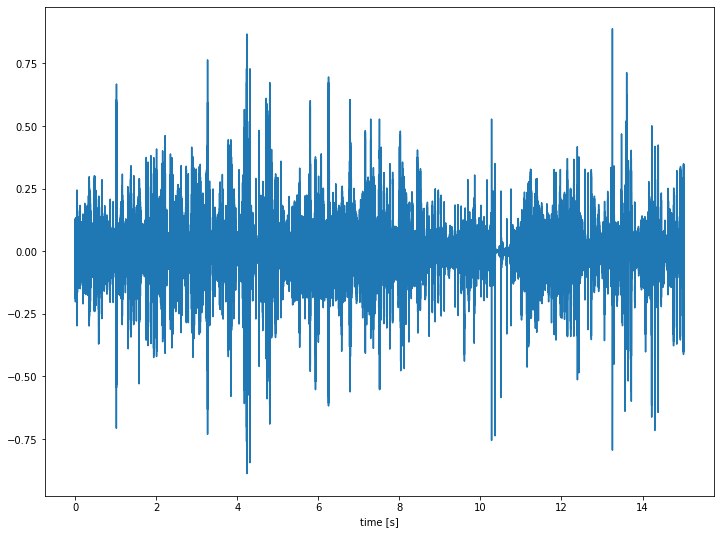

In [103]:
signal_full, sr = librosa.load(audiofile)
print(f'total audio duration of file {audiofile} is : {len(signal_full)/sr:.2f}s')

t = np.linspace(0,len(signal_full)/sr, len(signal_full))
plt.figure(figsize=(12,9))
plt.plot(t, signal_full)
plt.xlabel('time [s]')
plt.plot()

In [104]:
print('FULL DURATION AUDIO CLIP')

Audio(data=signal_full,rate=sr)

FULL DURATION AUDIO CLIP


[]

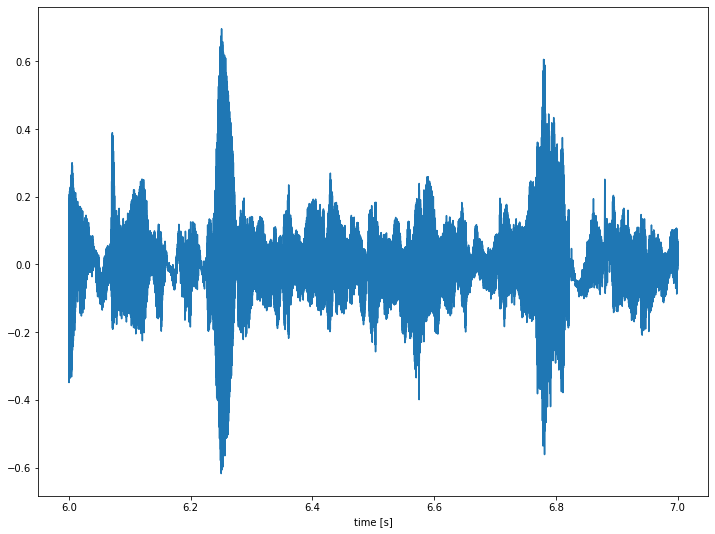

In [105]:
# choose a clip of the full audio file.
# start at 'signal_start' seconds
# and get a clip of duration 'signal_duration' seconds
signal_start = 6
signal_duration = 1

signal = signal_full[signal_start*sr:(signal_start + signal_duration)*sr]

t = np.linspace(signal_start,signal_start+signal_duration, len(signal))
plt.figure(figsize=(12,9))
plt.plot(t, signal)
plt.xlabel('time [s]')
plt.plot()

In [106]:
print('SELECTED PART OF AUDIO CLIP')

Audio(data=signal,rate=sr)

SELECTED PART OF AUDIO CLIP


## Modulation Spectrogram of original signal

Plot the modulation spectrograms of the full or clipped audio file

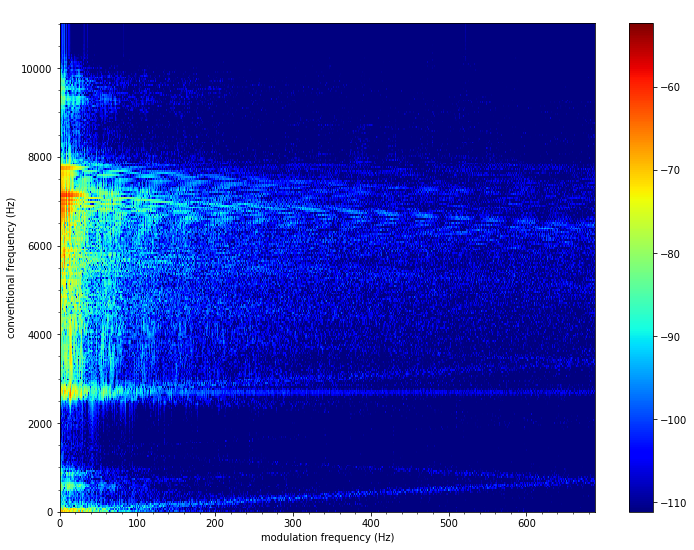

In [107]:

window_size = 512
window_shift = 16

#choose signal_full or signal as input
ama_input = signal

rfft_mod = ama.strfft_modulation_spectrogram(ama_input,
                                             sr,
                                             window_size,
                                             window_shift,
                                             channel_names=' ',
                                             win_function_y='boxcar',
                                             win_function_x='boxcar')


plt.figure(figsize=(12,9))
ama.plot_modulation_spectrogram_data(rfft_mod, c_map='jet')#,modf_range=[1,40])
plt.show()




---


Here is the modulation filtering part.

The process followed in the following sections is the following:

1) the original signal is split in frequency bands

2) for each of the frequency bands, calculate the amplitude envelope (AE)

3) each AE is passed through a lowpass filter 

4) the low-passed AE of each frequency band signal is divided by the AE of the original frequency band signal

5) the above ration for each frequency band is multiplied with the original signal of that band

6) a lowpass filter is again applied on all of the band signals resulted from step 5). The cut-off frequency used is 5% higher than the upper frequency of the corresponding bandpass

7) Add all bands together

---

Some modulation spectrograms and audios are created at the end to compare original and final product.

## Filter bank original signal

create frequency bands for the filter bank

In [110]:
freqs = [10]

for i in range(1,11):
  freqs.append(freqs[i-1]*2)

print('the frequency intervals are:',freqs)

the frequency intervals are: [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240]


apply bandpass filter and plot results

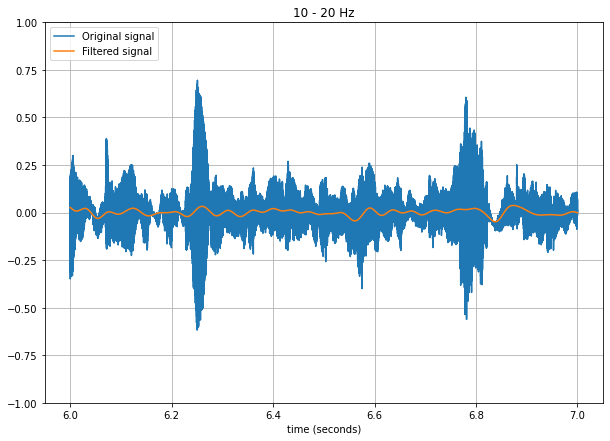

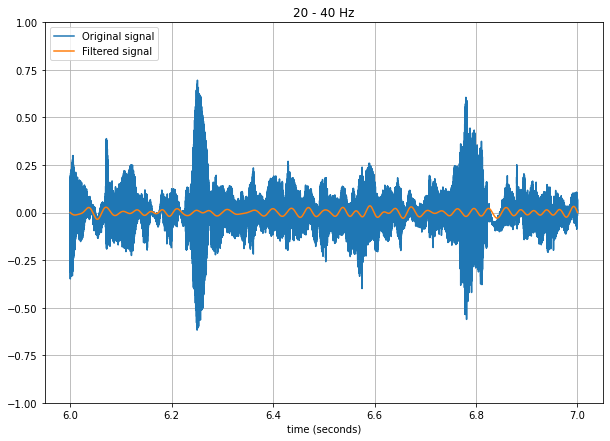

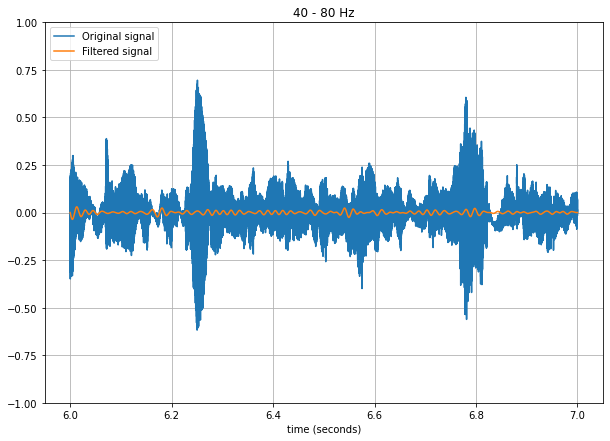

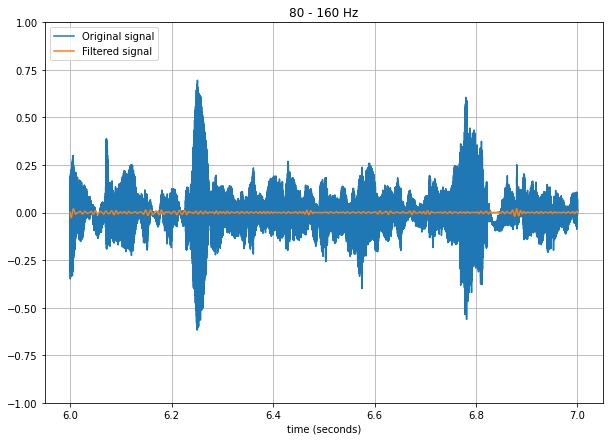

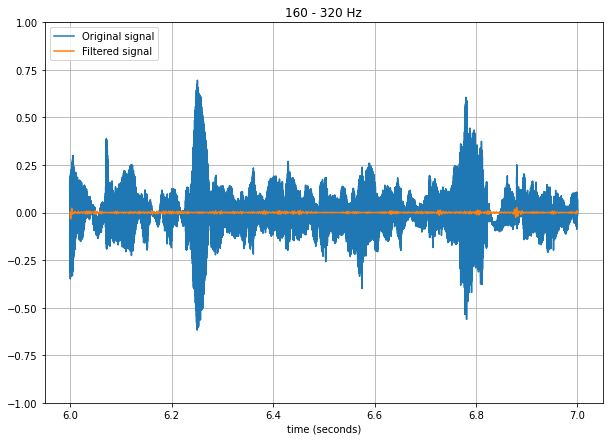

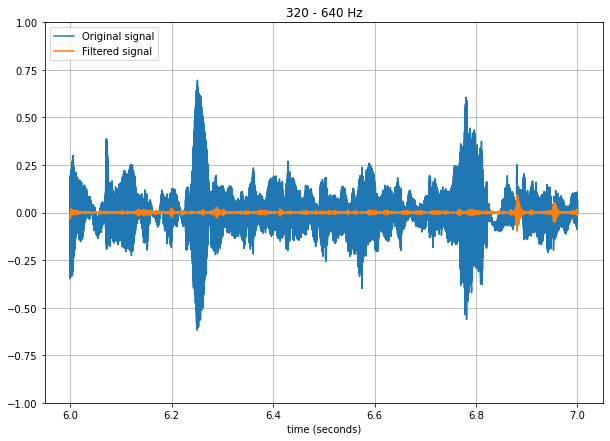

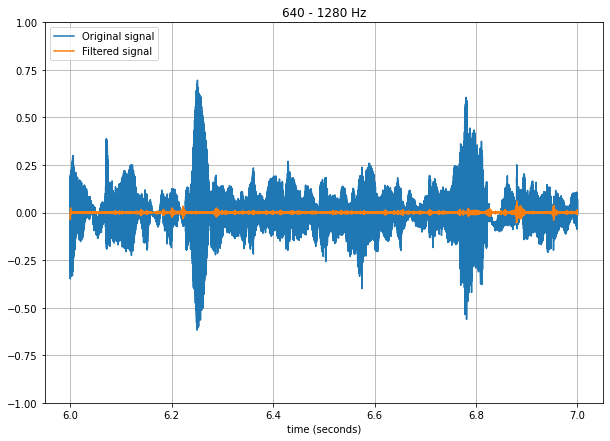

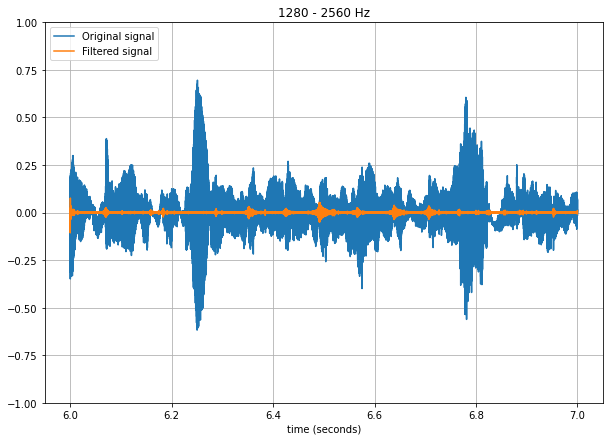

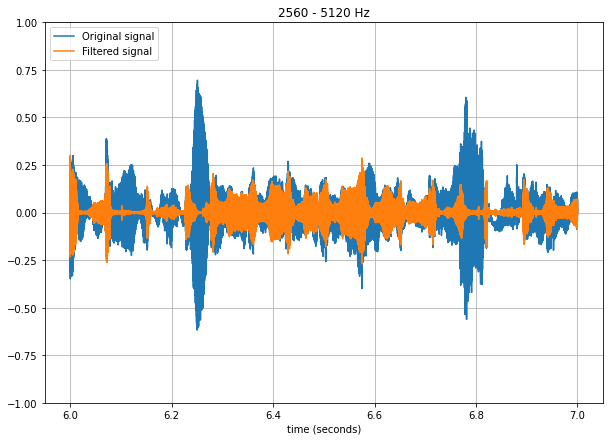

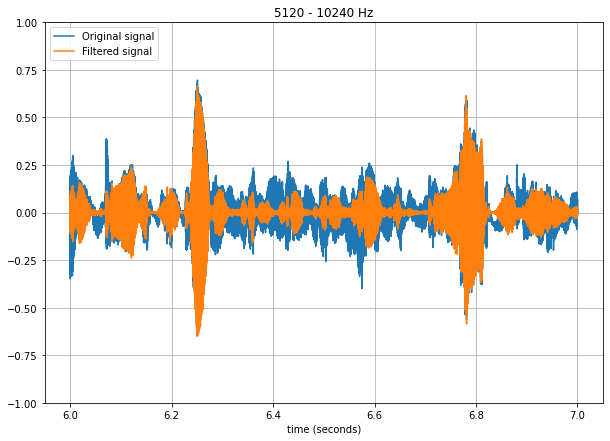

In [112]:
# timepoints for the plots
t = np.linspace(signal_start, signal_start + signal_duration, len(signal), endpoint=False)


bp_signal = []
for i in range(len(freqs)-1):
  lowcut = freqs[i]
  highcut = freqs[i+1]

  #bp_signal.append(butter_bandpass_filter(signal, lowcut, highcut, sr, order=6))
  bp_signal.append(bandpass(signal, sr, lowcut, highcut, bandwidth=50))

  plt.figure(figsize=(10,7))
  plt.clf()
  plt.plot(t, signal, label='Original signal')
  plt.plot(t, bp_signal[i], label='Filtered signal' )
  plt.xlabel('time (seconds)')
  plt.grid(True)
  plt.axis('tight')
  plt.ylim([-1,1])
  plt.legend(loc='upper left')
  plt.title(str(lowcut)+' - '+str(highcut)+' Hz')
  plt.show()


## Get Amplitude Envelope

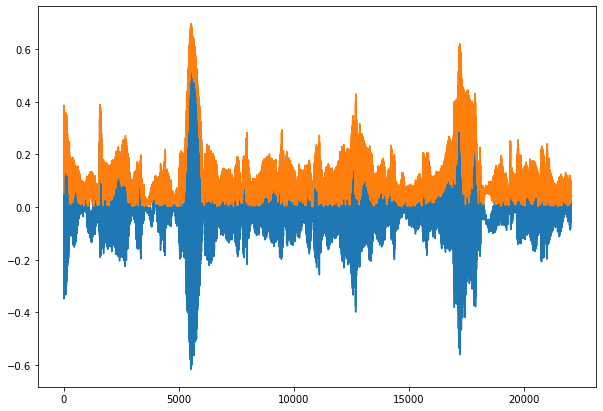

In [113]:
z = (hilbert(signal)) #form the analytical signal
amp_env = np.abs(z) #envelope extraction
inst_phase = np.unwrap(np.angle(z))#inst phase
inst_freq = np.diff(inst_phase)/(2*np.pi)*sr #inst frequency

plt.figure(figsize=(10,7))
plt.plot(signal)
plt.plot(amp_env)
#plt.ylim([-0.5,0.5])
plt.show()

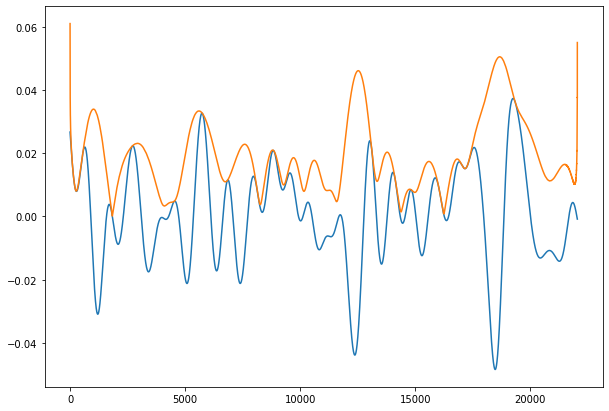

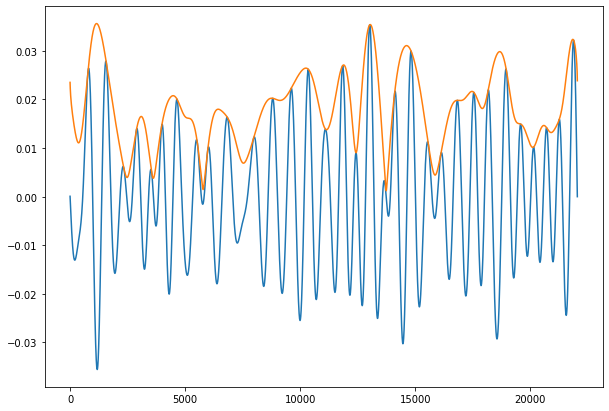

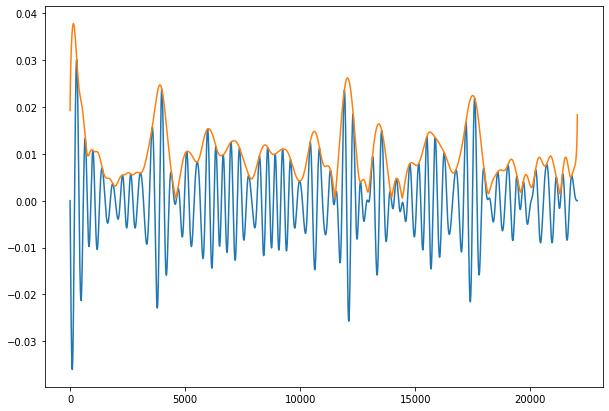

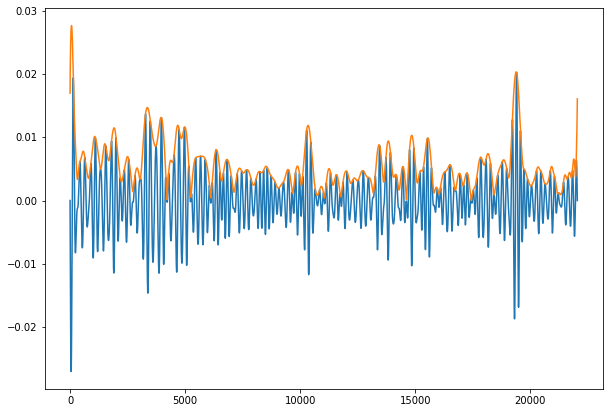

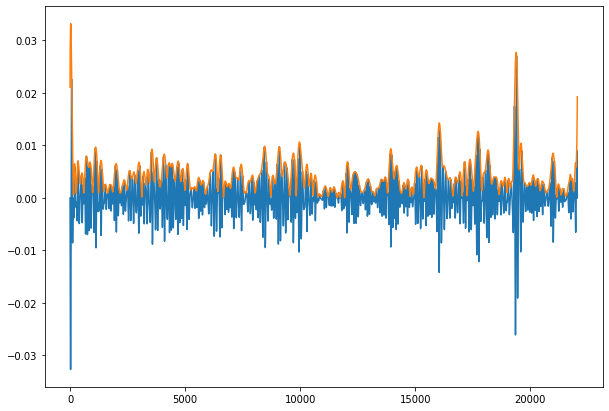

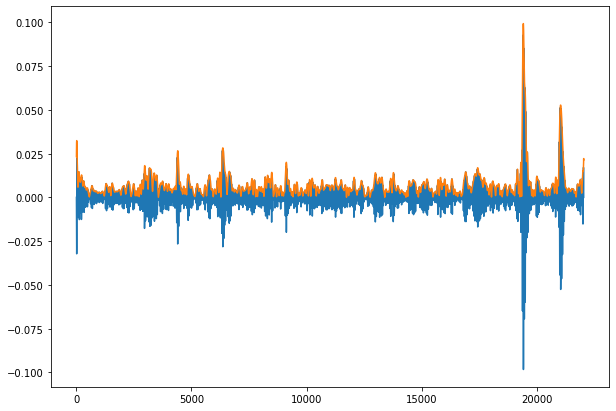

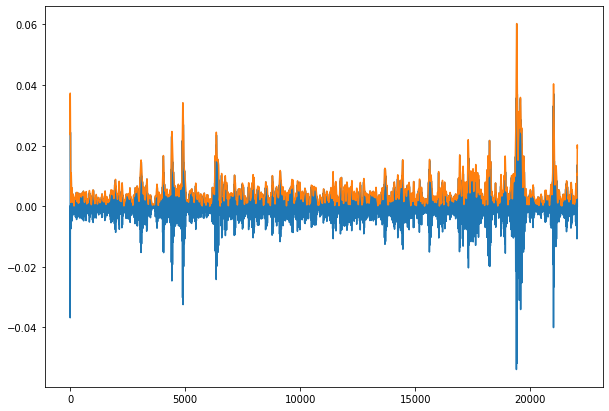

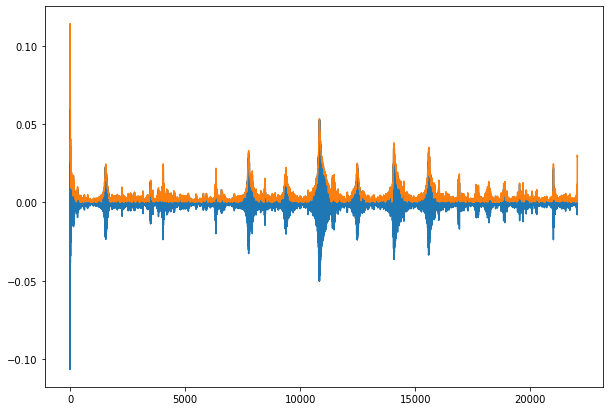

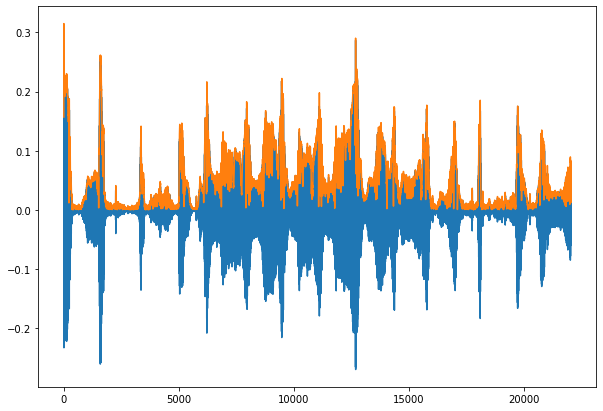

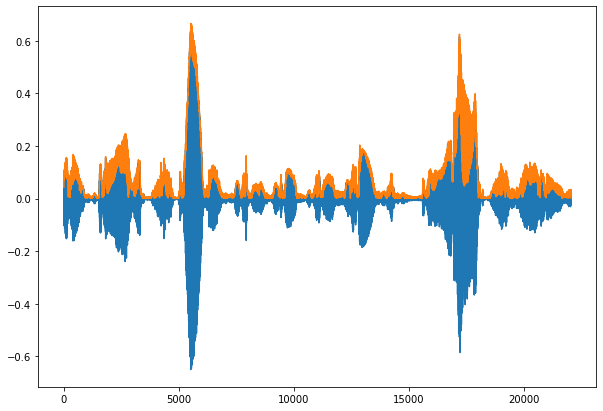

In [114]:
# get the signal A.E. using hilbert transform
amp_env = []
inst_phase = []
for s in bp_signal:
  z = (hilbert(s)) #form the analytical signal
  amp_env.append(np.abs(z)) #envelope extraction
  inst_phase.append(np.unwrap(np.angle(z)))#inst phase
  inst_freq = np.diff(inst_phase)/(2*np.pi)*sr #inst frequency

  plt.figure(figsize=(10,7))
  plt.plot(s)
  plt.plot(amp_env[-1])
  #plt.ylim([-0.5,0.5])
  plt.show()

## Lowpass AE using FIR filter 

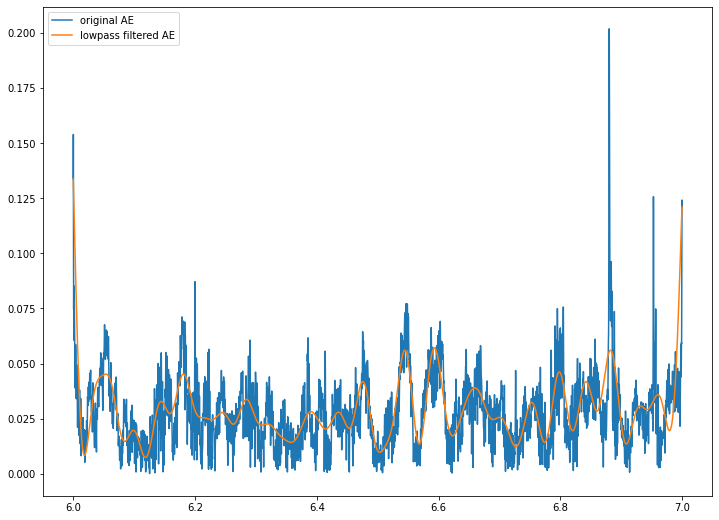

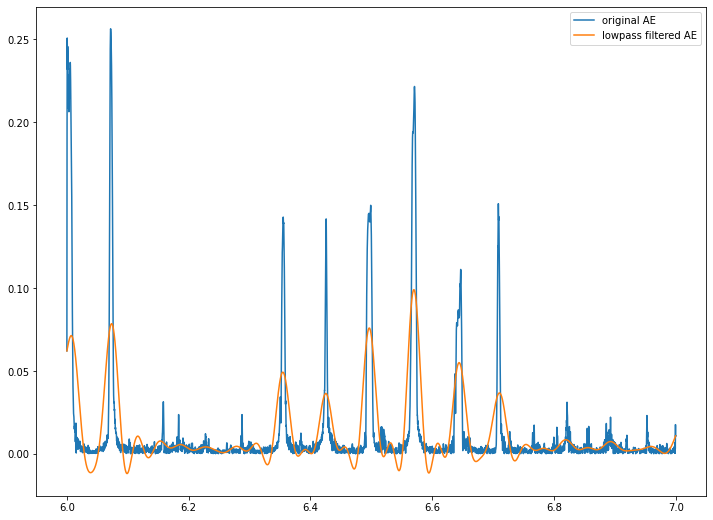

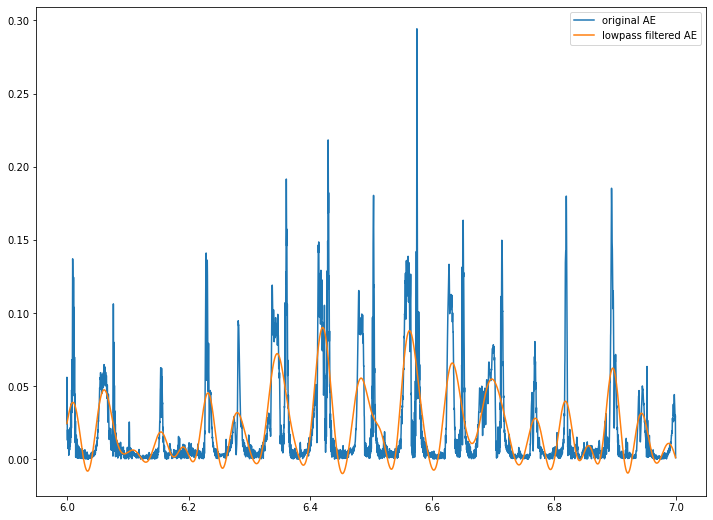

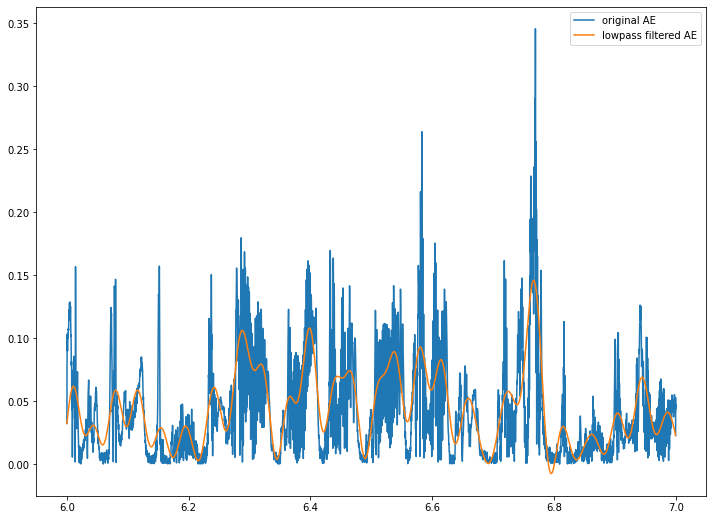

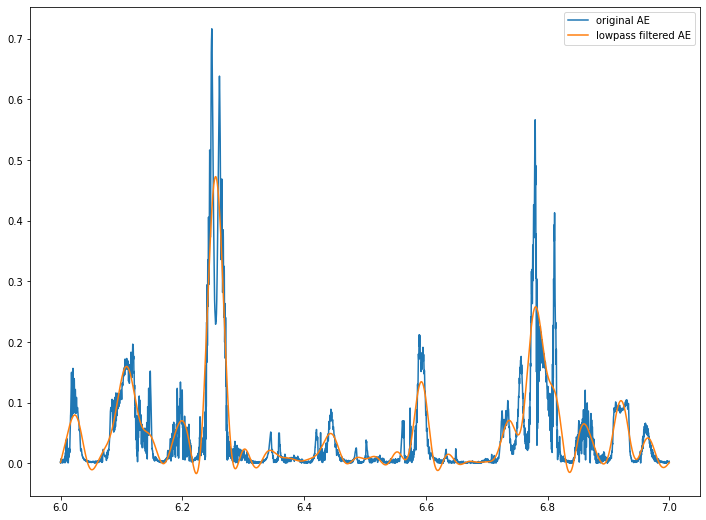

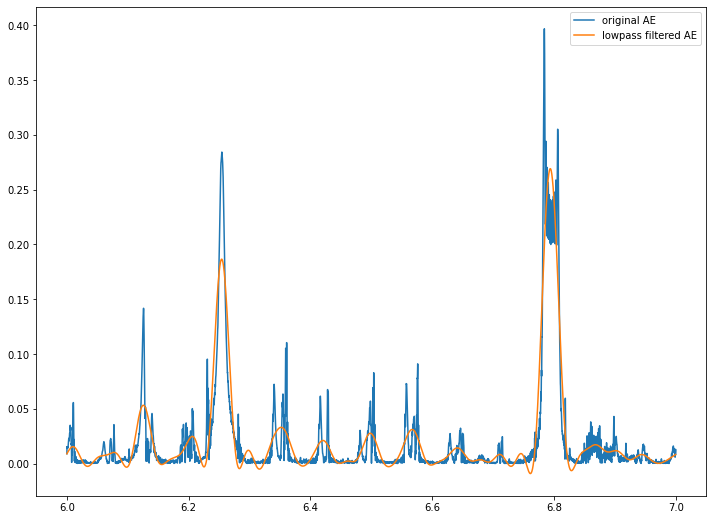

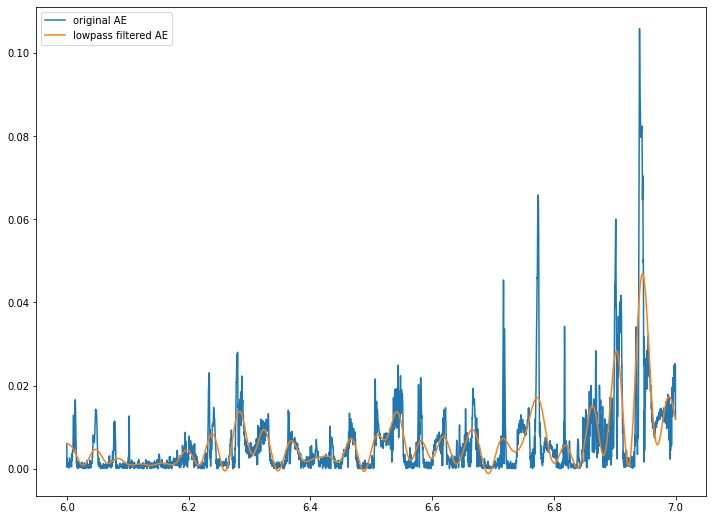

In [21]:

# cut-off frequency (upper bound)
fc=30
bandwidth=20
ripple_db=100.0

ae_lowpass=[]
for ae in amp_env:
  ae_lowpass.append(lowpass(ae, sr, fc, bandwidth,ripple_db))
  plt.figure(figsize=(12,9))
  plt.plot(t,ae,label='original AE')
  plt.plot(t,ae_lowpass[-1],label='lowpass filtered AE')
  plt.legend()
  plt.show()

## Bandstop AE using Butterworth bandstop filter

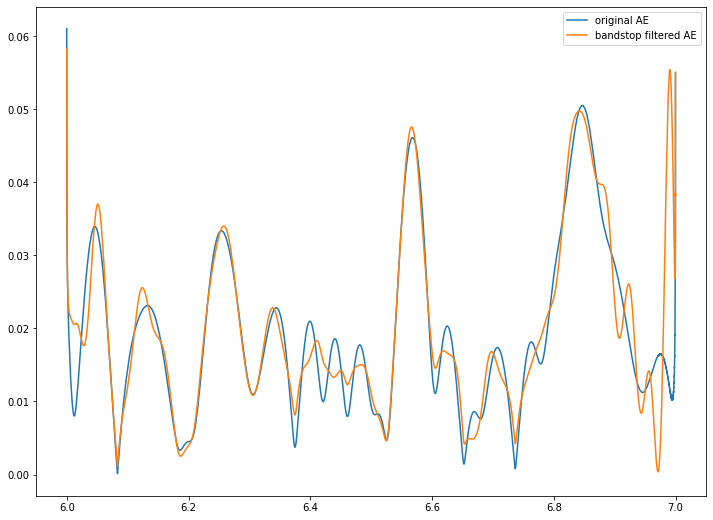

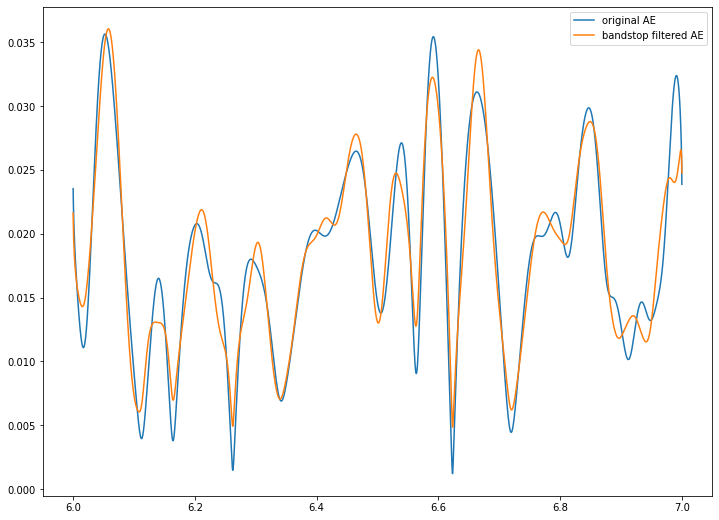

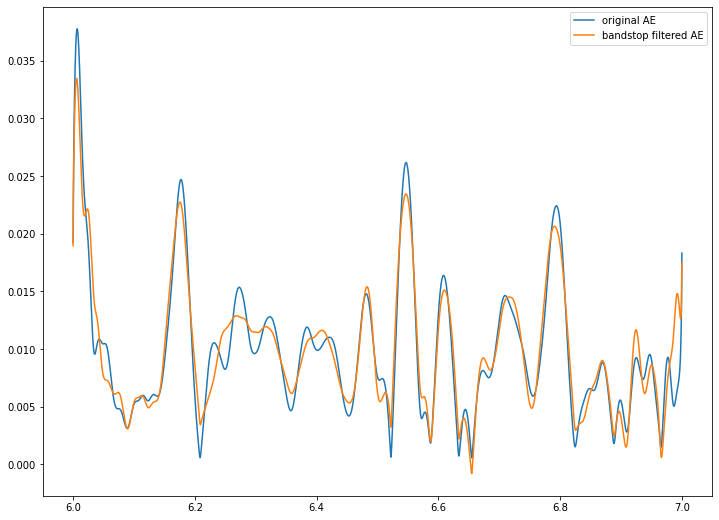

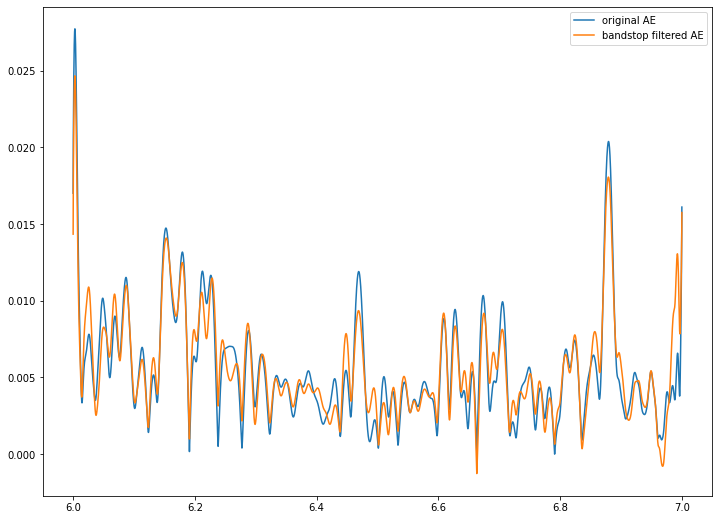

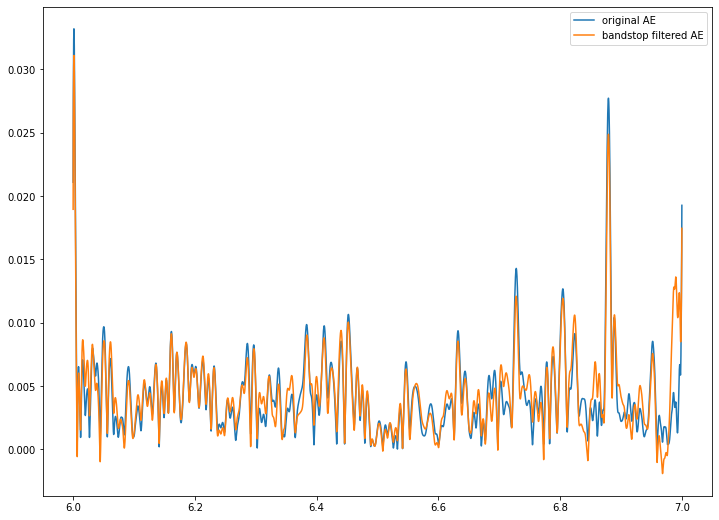

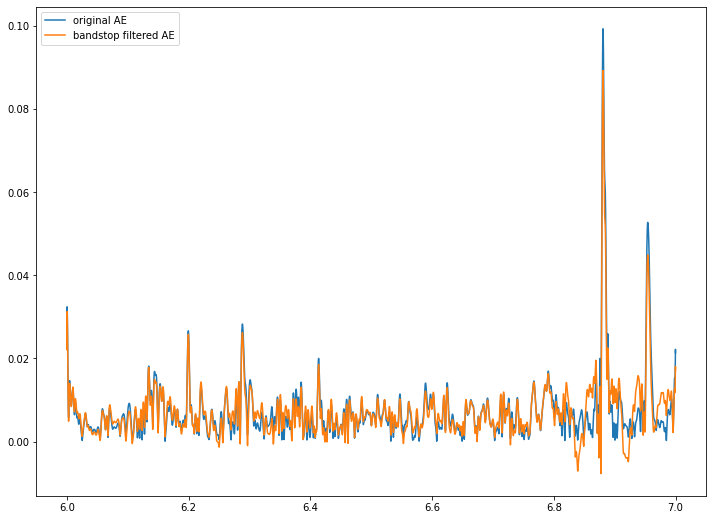

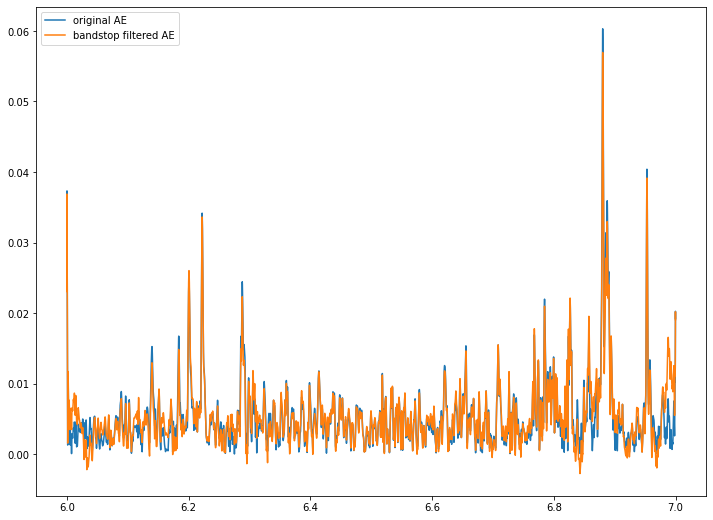

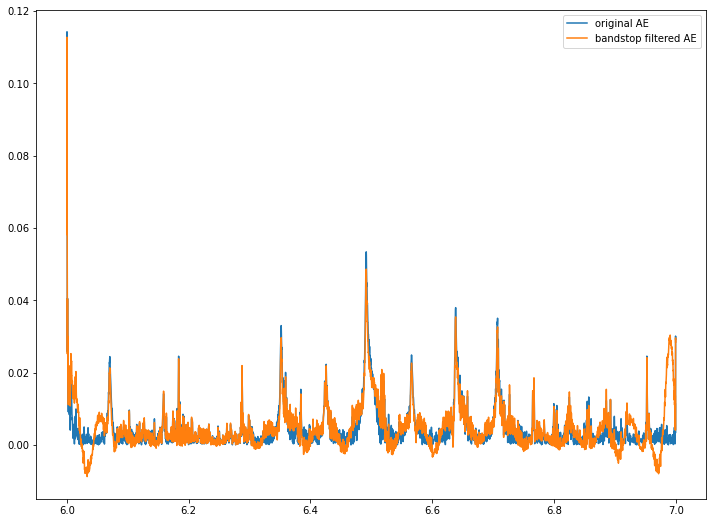

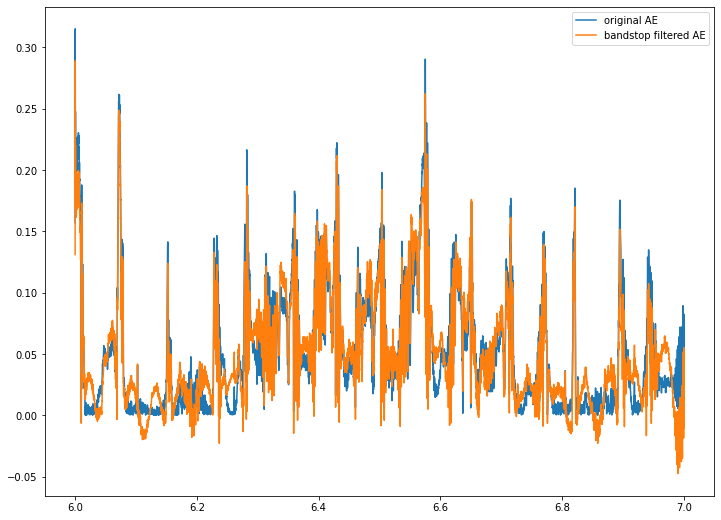

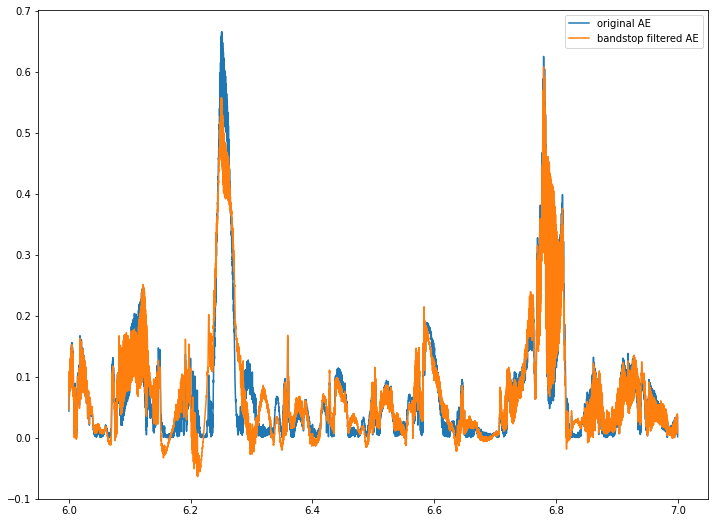

In [115]:

# cut-off frequency (upper bound)
low_f = 20
high_f = 30
order = 3

ae_bandstop=[]
for ae in amp_env:
  ae_bandstop.append(butter_bandstop_filter(ae, low_f, high_f, sr, order))
  plt.figure(figsize=(12,9))
  plt.plot(t,ae,label='original AE')
  plt.plot(t,ae_bandstop[-1],label='bandstop filtered AE')
  plt.legend()
  plt.show()

In [116]:
ae_filtered = ae_bandstop

## Half wave rectification


filtering of the AE might introduce negative amplitudes. Perform a half-wave rectification, by setting to sero all negative values.

In [117]:
# define a function that does half-wave rectification
def half_rectify(signal):
  '''
  Half rectifies a signal: set all negative values to zero
  input: a signal in the form of a list/array
  output: rectified signal list
  '''

  signal = list(map(lambda x: 0 if x < 0 else x, signal))  

  return signal

In [118]:
# apply rectification in all filtered envelopes 
ae_filtered_rect = []

for envelope in ae_filtered:
  ae_filtered_rect.append(half_rectify(envelope))

## Modify original BP signal with new envelope

In [119]:
envR  = [i / j for i, j in zip(ae_filtered_rect , amp_env)] # calculate the ratio
filt_bp_signal = [ i * j for i,j in zip(bp_signal, envR)] # multiply original audio with ratio


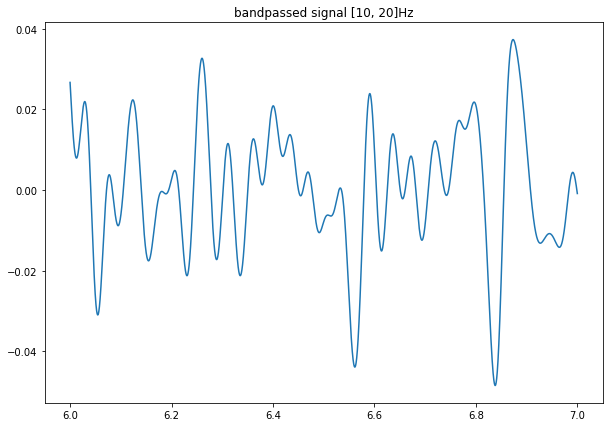

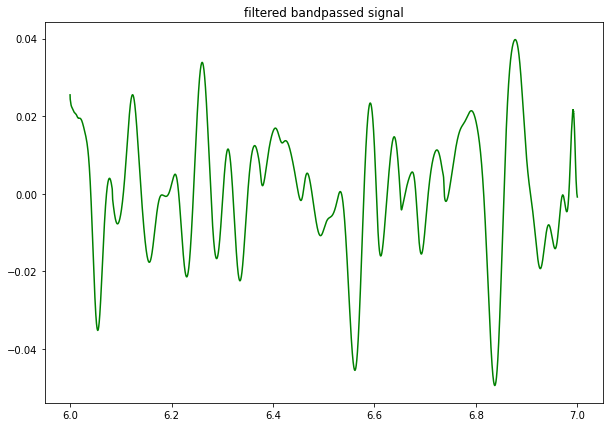

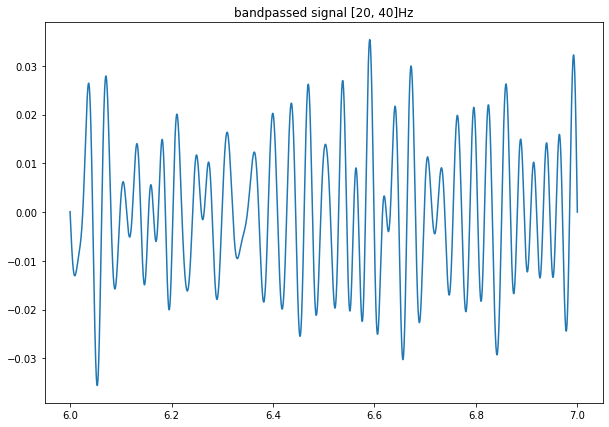

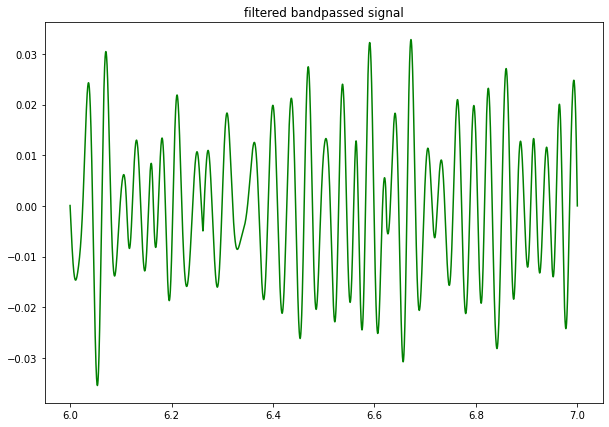

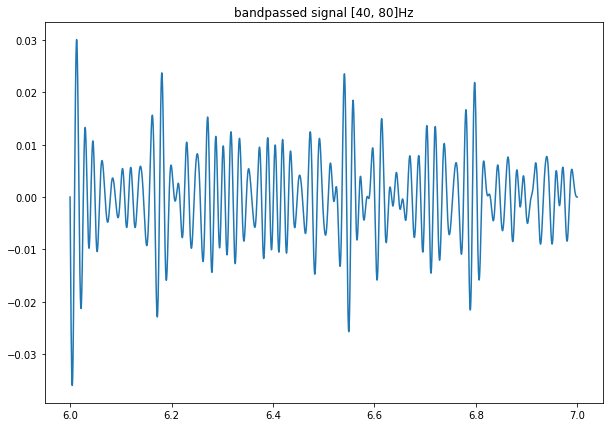

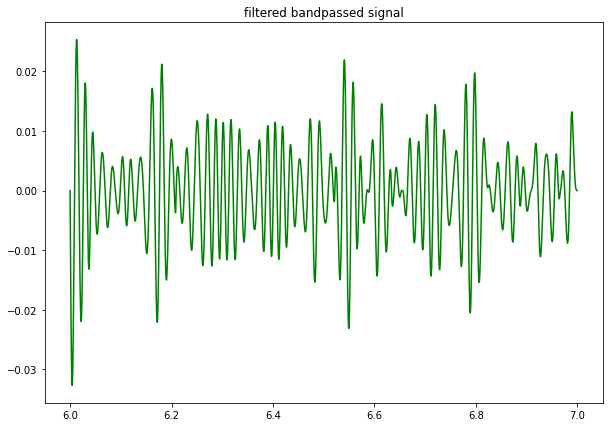

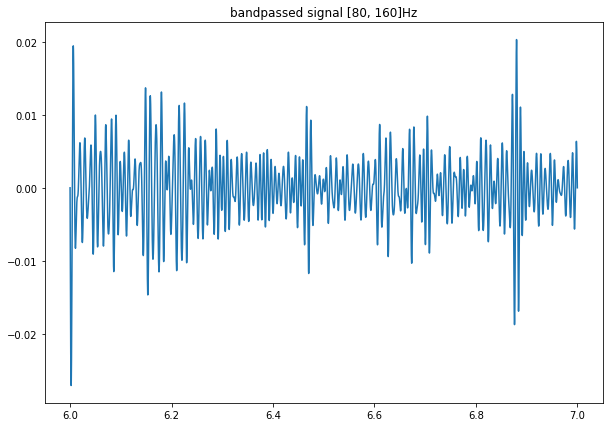

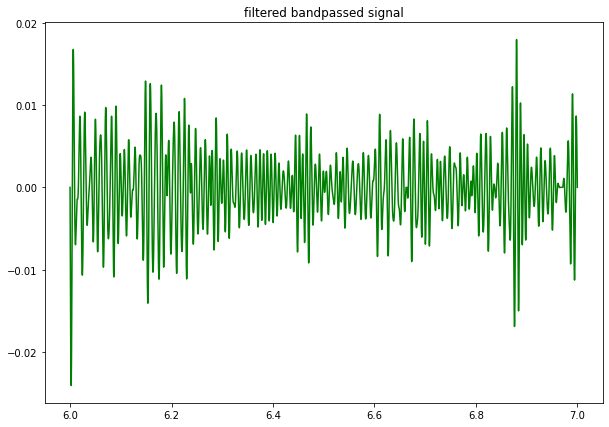

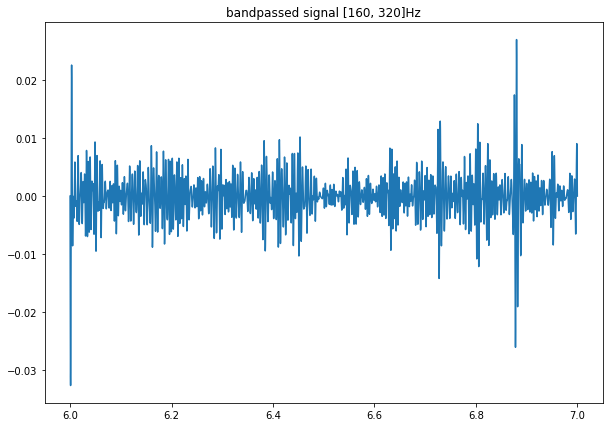

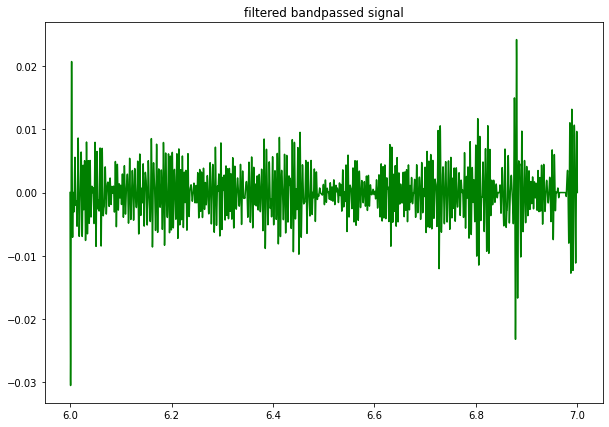

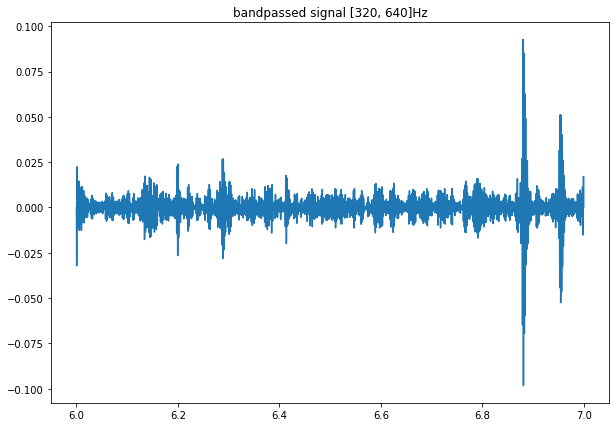

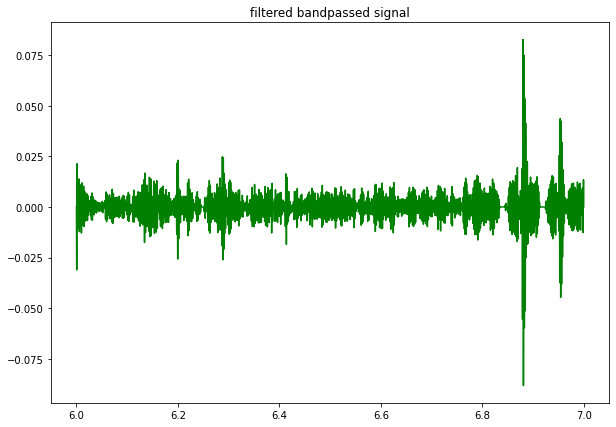

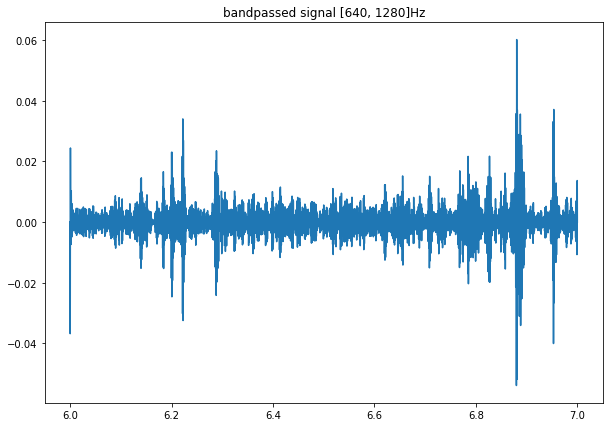

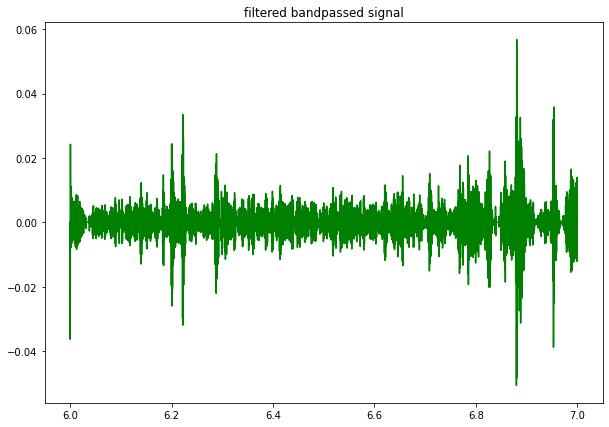

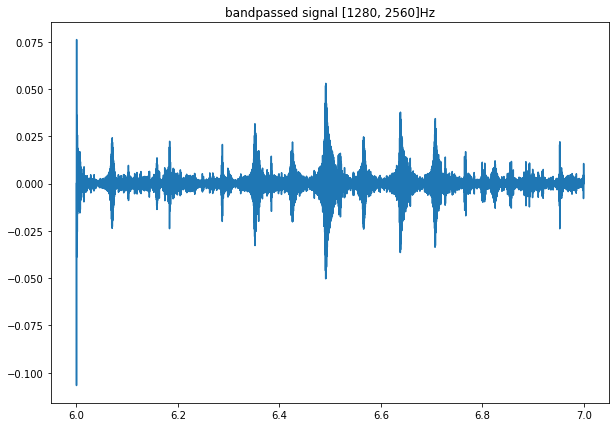

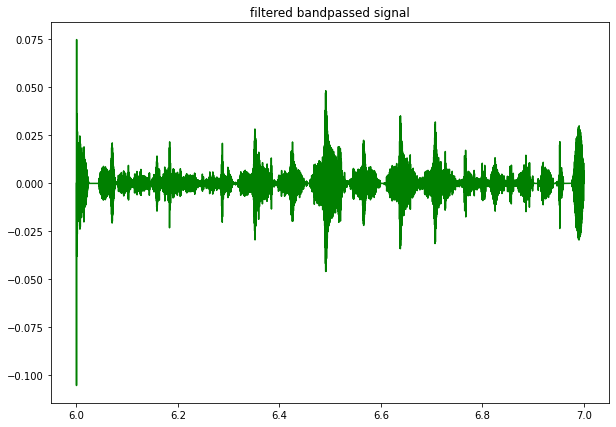

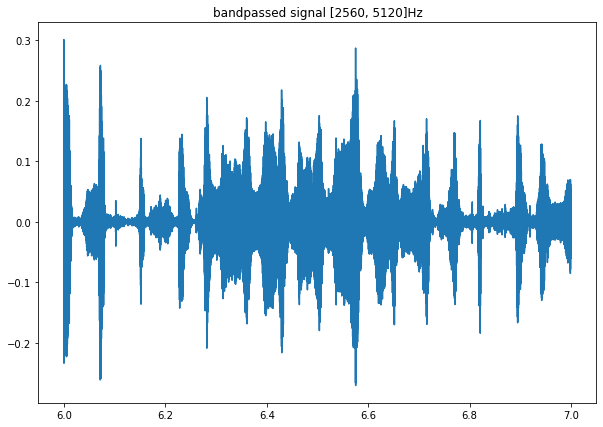

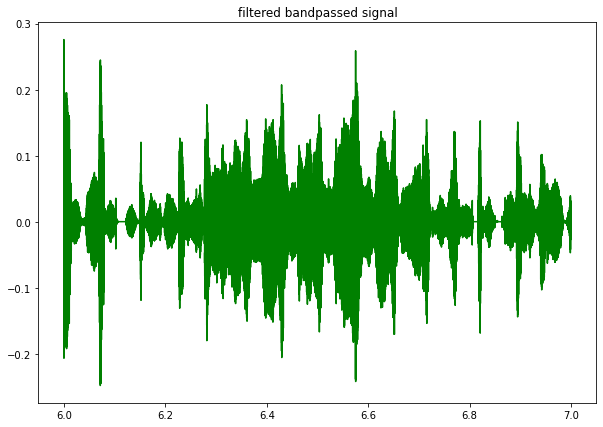

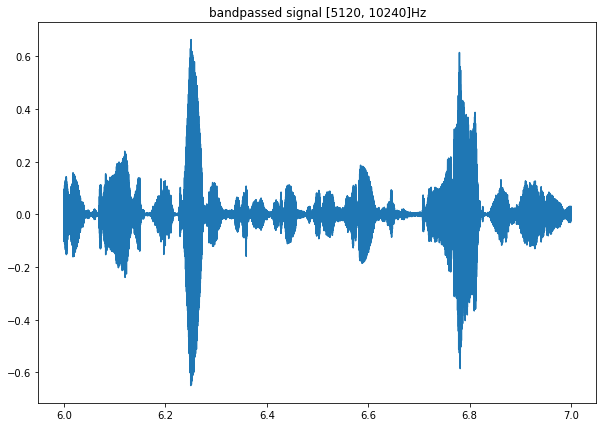

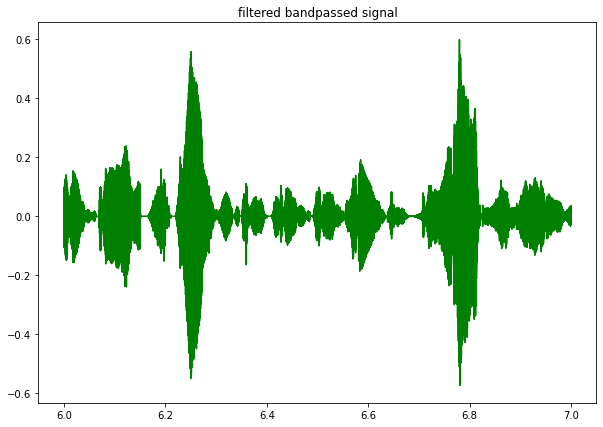

In [120]:

for i in range(len(filt_bp_signal)):
  
  plt.figure(figsize=(10,7))
  plt.figure(1)
  plt.title(f'bandpassed signal {[freqs[i] , freqs[i+1]]}Hz')
  plt.plot(t,bp_signal[i])
  plt.figure(figsize=(10,7))
  plt.figure(2)
  plt.title('filtered bandpassed signal')
  plt.plot(t,filt_bp_signal[i],c='g')
  plt.show()


## Lowpass modified signals 

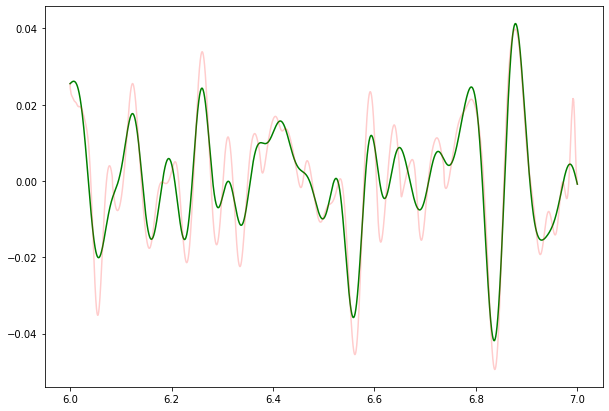

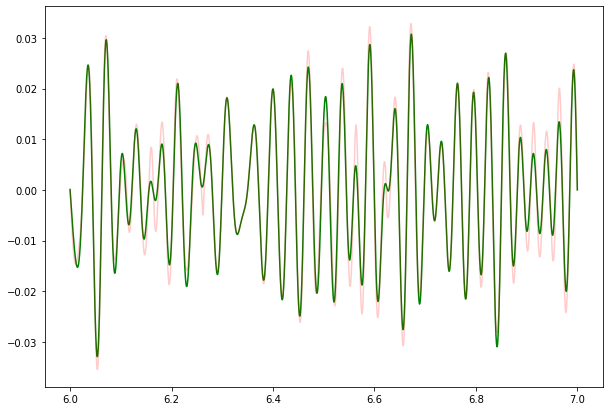

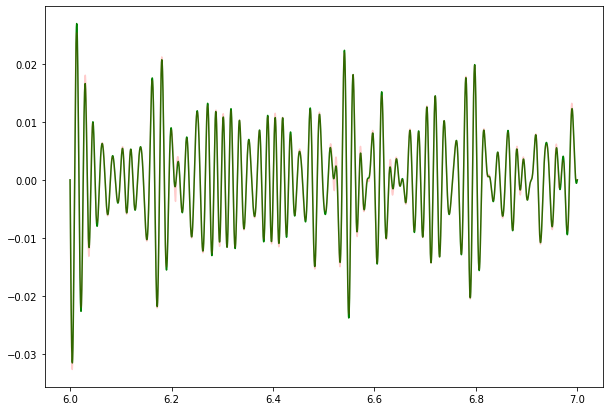

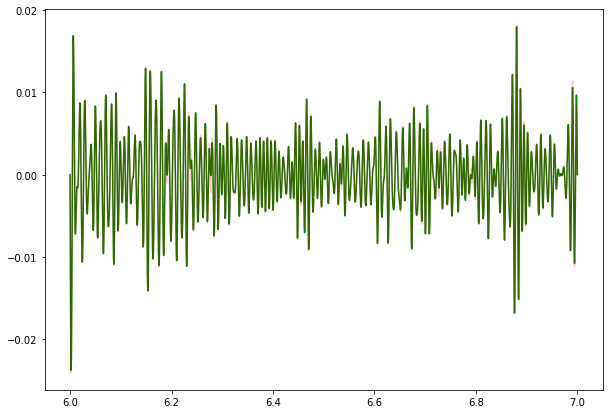

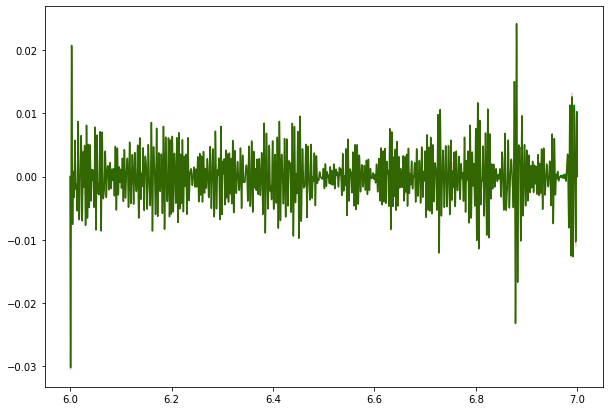

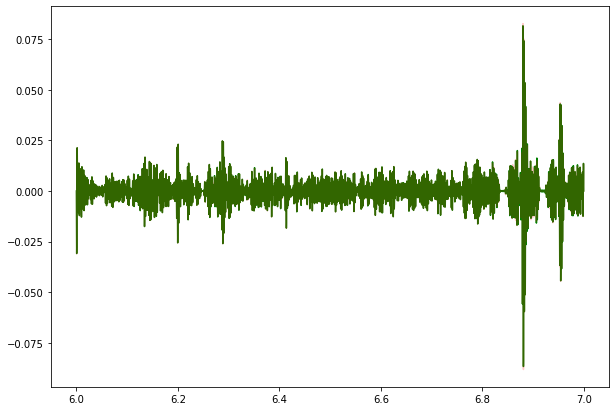

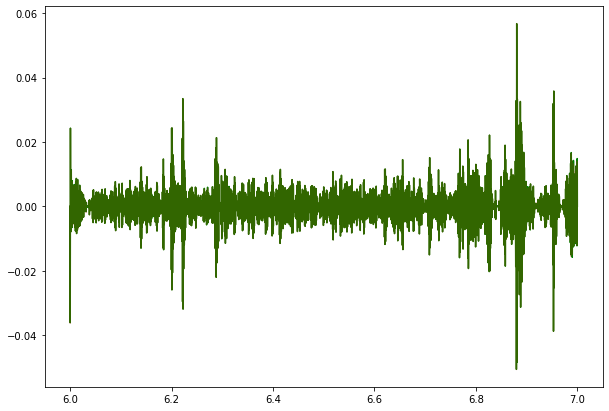

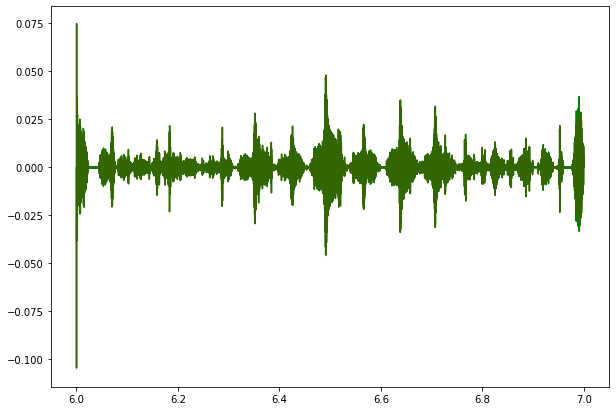

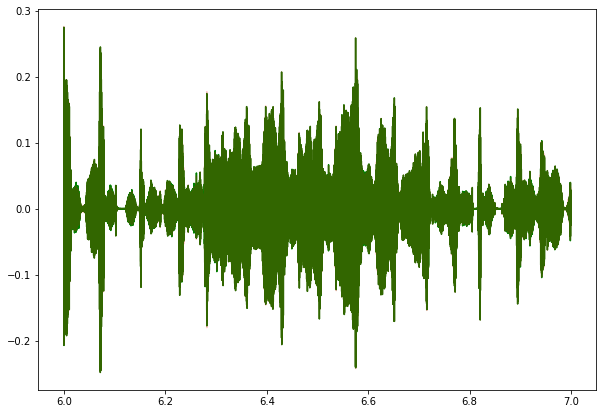

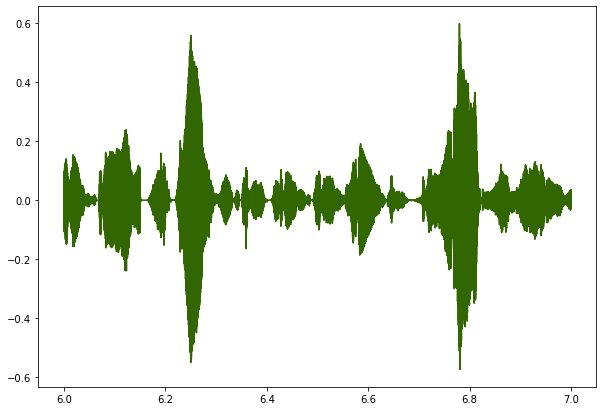

In [122]:
lp_filt_bp_signal = []
bandwidth=20
ripple_db=65

for i in range(len(filt_bp_signal)):
  fc=freqs[i+1]*1.05
  lp_filt_bp_signal.append(lowpass(filt_bp_signal[i], sr, fc, bandwidth,ripple_db))

  plt.figure(figsize=(10,7))
  plt.plot(t,lp_filt_bp_signal[i],c='g')
  plt.plot(t,filt_bp_signal[i],c='r',alpha=0.2)
  plt.show()

## Bandpass modified band signals

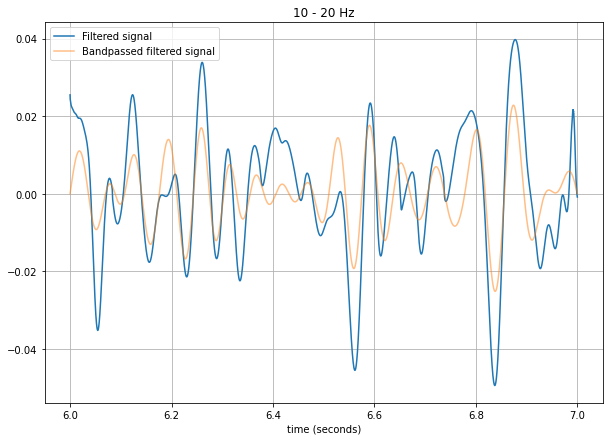

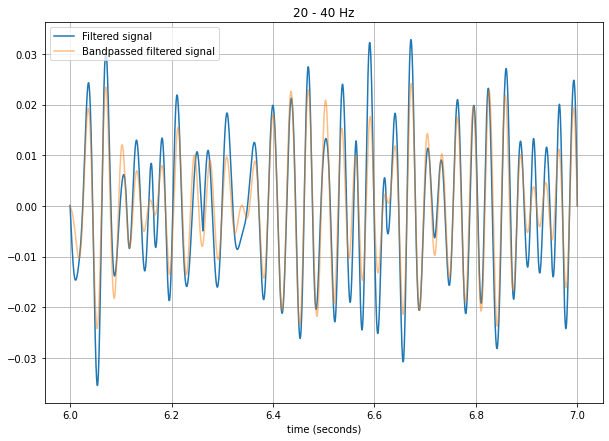

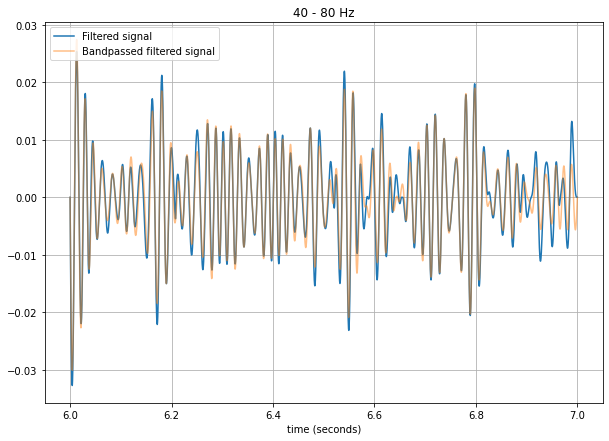

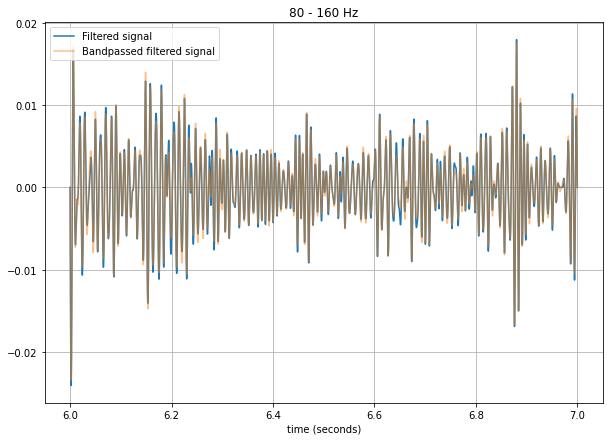

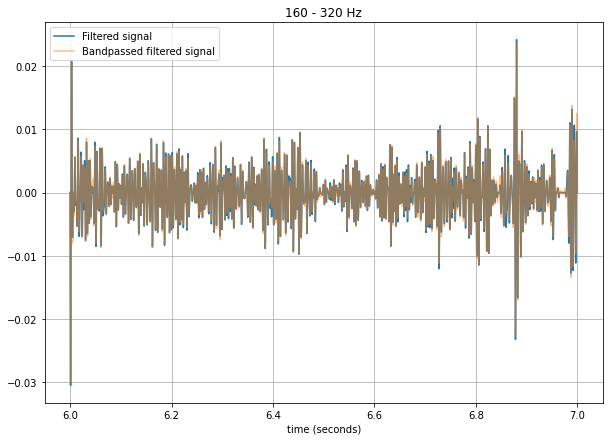

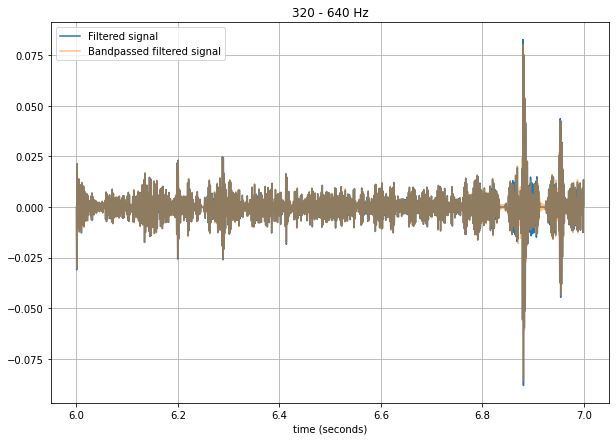

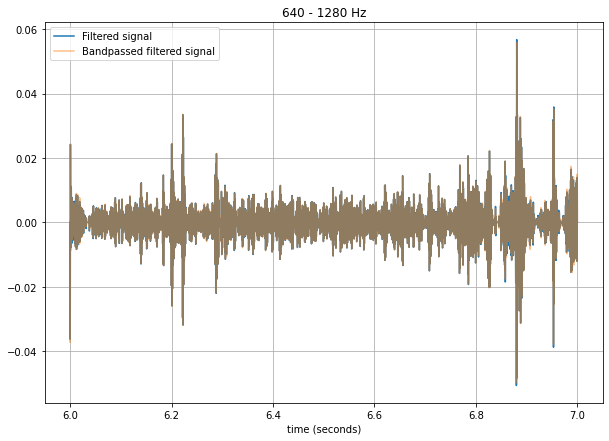

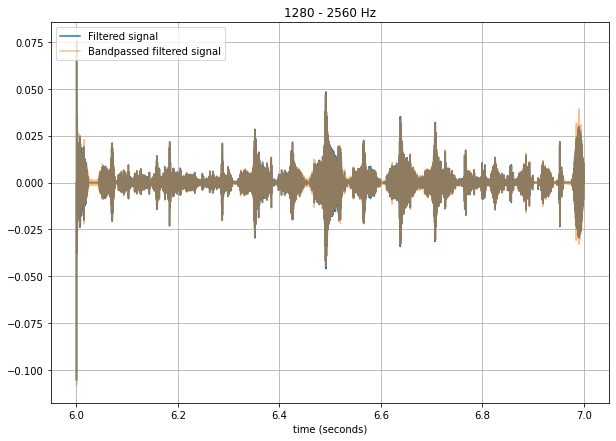

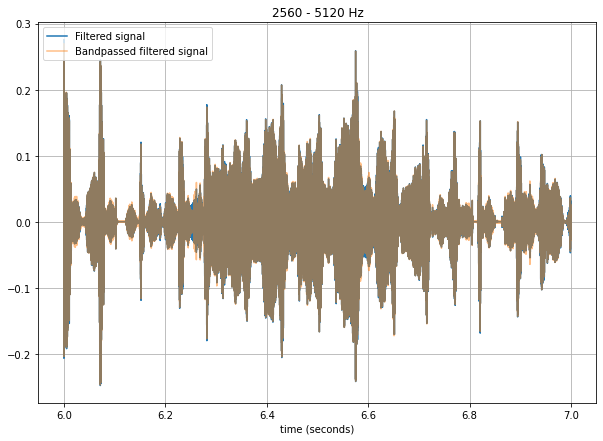

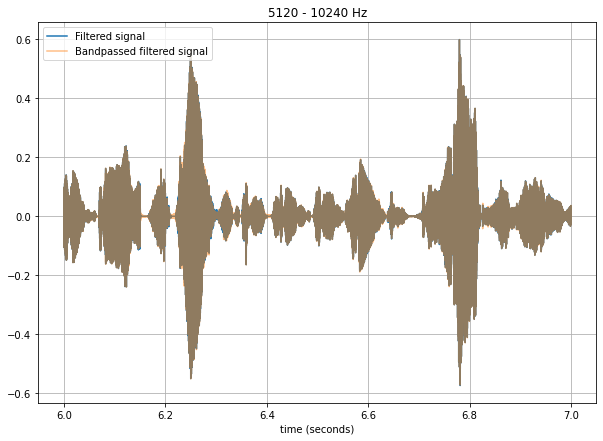

In [134]:
bp_filt_bp_signal = []

for i in range(len(freqs)-1):
  lowcut = freqs[i]
  highcut = freqs[i+1]

  bp_filt_bp_signal.append(bandpass(filt_bp_signal[i], sr, lowcut, highcut, bandwidth=20))

  plt.figure(figsize=(10,7))
  plt.clf()
  plt.plot(t, filt_bp_signal[i], label='Filtered signal')
  plt.plot(t, bp_filt_bp_signal[i], label='Bandpassed filtered signal',alpha=0.5)
  plt.xlabel('time (seconds)')
  plt.grid(True)
  plt.axis('tight')
  #plt.ylim([-1,1])
  plt.legend(loc='upper left')
  plt.title(str(lowcut)+' - '+str(highcut)+' Hz')
  plt.show()


## Sum all modified bandpass signals

In [135]:
mod_signal=sum(bp_filt_bp_signal)

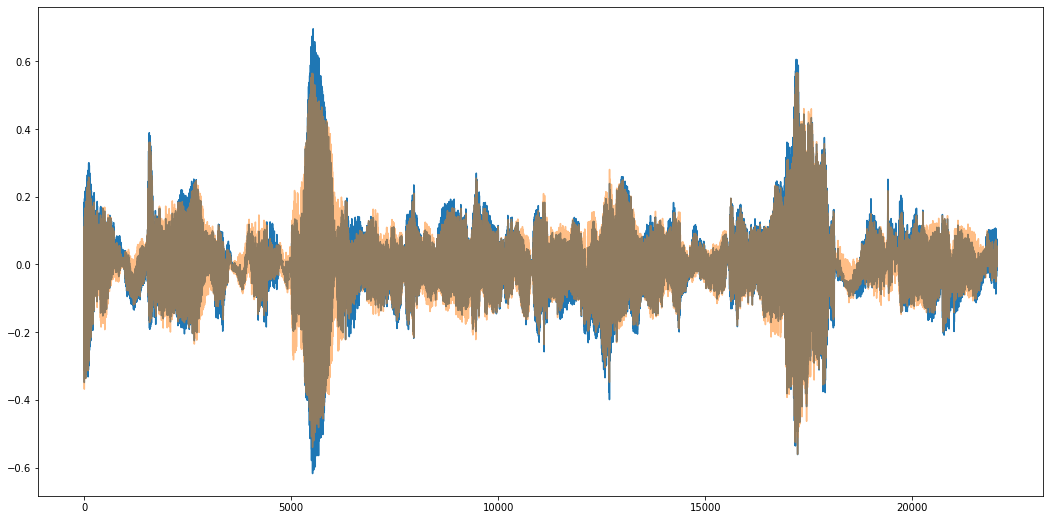

In [136]:
plt.figure(figsize=(18,9))
plt.plot(signal)
#plt.show()


#plt.figure(figsize=(12,9))
plt.plot(mod_signal,alpha=0.5)
plt.show()

## Compare modulation spectrograms

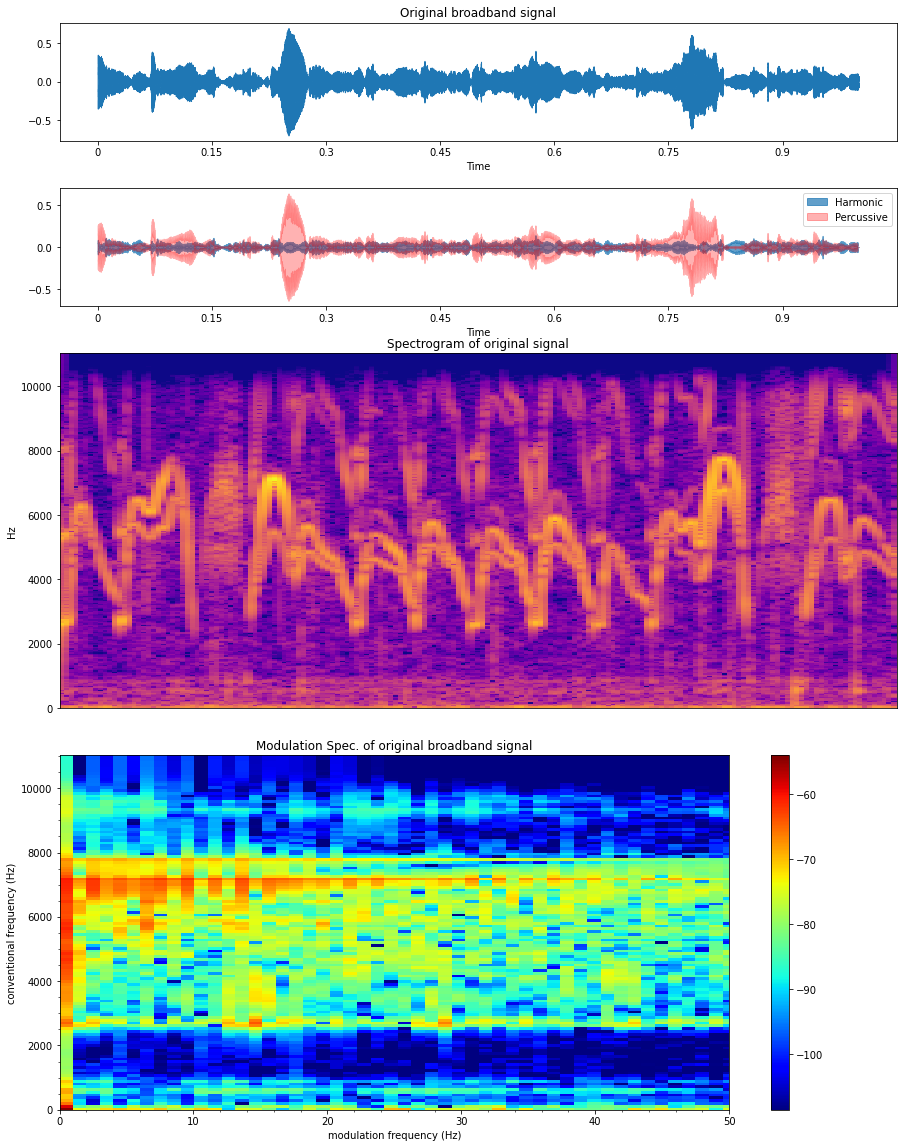

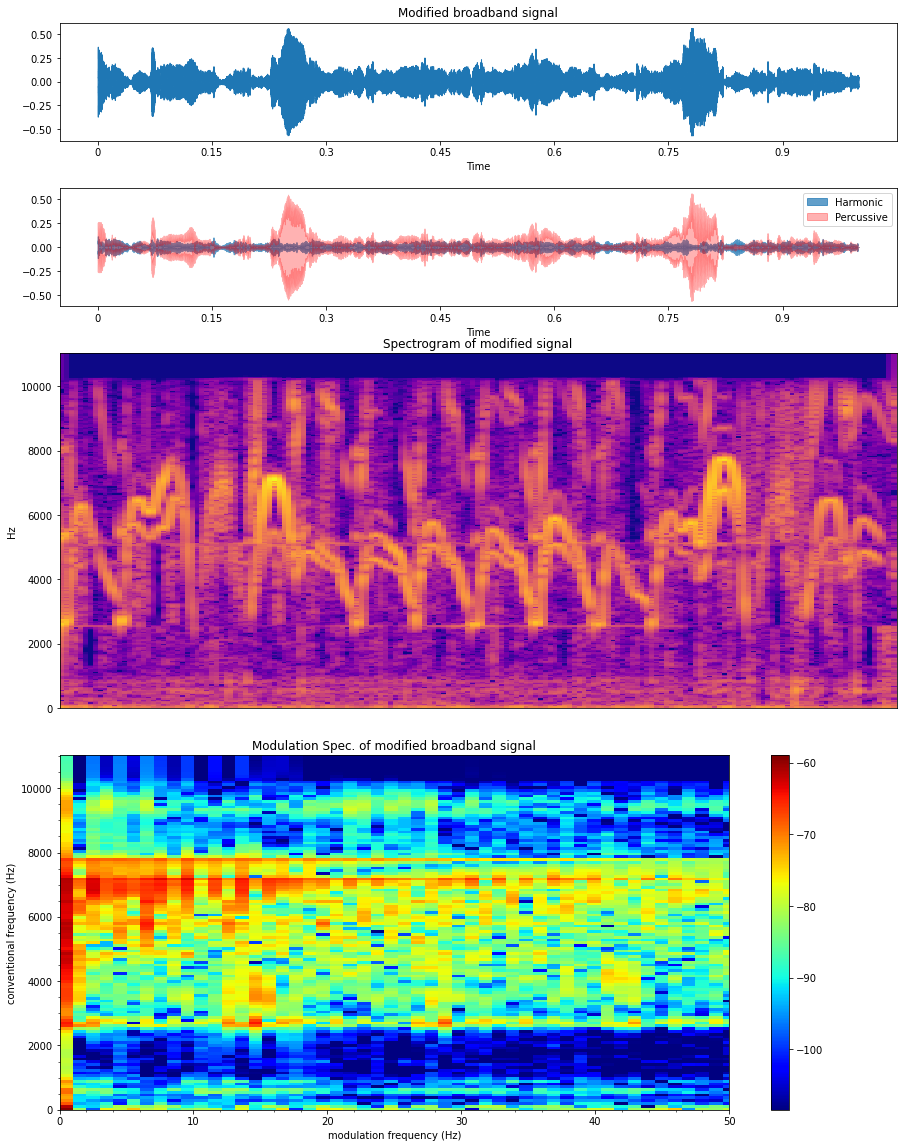

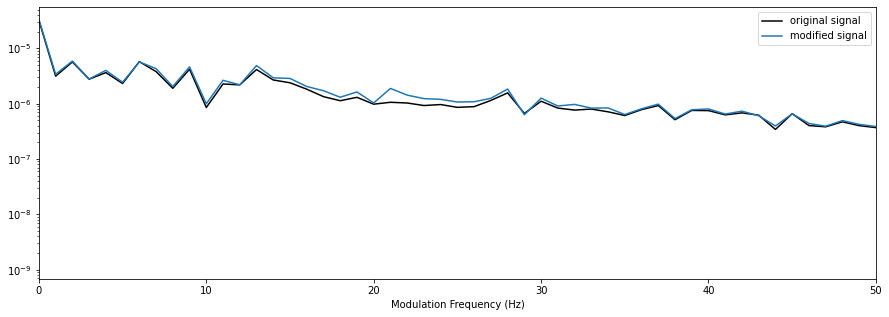

In [137]:
window_size = 256
window_shift = 16

#Original signal

y_harm, y_perc = librosa.effects.hpss(signal)
stft = librosa.stft(signal,n_fft=512,hop_length=128)

spec_power = np.abs(stft)**2
p_to_db = librosa.power_to_db(spec_power)
modul_spec_orig=np.sum(rfft_mod['power_modulation_spectrogram'],axis=0)

ama_input = signal

rfft_mod = ama.strfft_modulation_spectrogram(ama_input,
                                             sr,
                                             window_size,
                                             window_shift,
                                             channel_names=' ',
                                             win_function_y='boxcar',
                                             win_function_x='boxcar')


fig, ax = plt.subplots(nrows=4, sharex=False,gridspec_kw={'height_ratios': [1, 1,3, 3]},figsize=(15,20))

librosa.display.waveshow(signal, sr=sr, ax=ax[0])
librosa.display.waveshow(y_harm, sr=sr, alpha=0.7,  label='Harmonic',ax=ax[1])
librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.3, label='Percussive',ax=ax[1])
librosa.display.specshow(p_to_db, sr=sr,y_axis='linear',ax = ax[2], cmap='plasma')

ama.plot_modulation_spectrogram_data(rfft_mod, c_map='jet')#,modf_range=[1,40])

ax[0].set_title('Original broadband signal')
ax[2].set_title('Spectrogram of original signal')
ax[3].set_title('Modulation Spec. of original broadband signal')
ax[3].set_xlim([0,50])
ax[1].legend()
plt.show()


# Modified signal

y_harm, y_perc = librosa.effects.hpss(mod_signal)
stft = librosa.stft(mod_signal,n_fft=512,hop_length=128)
spec_power = np.abs(stft)**2
p_to_db = librosa.power_to_db(spec_power)
modul_spec_mod=np.sum(rfft_mod['power_modulation_spectrogram'],axis=0)


ama_input = mod_signal

rfft_mod = ama.strfft_modulation_spectrogram(ama_input,
                                             sr,
                                             window_size,
                                             window_shift,
                                             channel_names=' ',
                                             win_function_y='boxcar',
                                             win_function_x='boxcar')


fig, ax = plt.subplots(nrows=4, sharex=False,gridspec_kw={'height_ratios': [1, 1,3, 3]},figsize=(15,20))

librosa.display.waveshow(mod_signal, sr=sr, ax=ax[0])
librosa.display.waveshow(y_harm, sr=sr, alpha=0.7,  label='Harmonic',ax=ax[1])
librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.3, label='Percussive',ax=ax[1])
librosa.display.specshow(p_to_db, sr=sr,y_axis='linear',ax = ax[2], cmap='plasma')

ama.plot_modulation_spectrogram_data(rfft_mod, c_map='jet')#,modf_range=[1,40])

ax[0].set_title('Modified broadband signal')
ax[2].set_title('Spectrogram of modified signal')
ax[3].set_title('Modulation Spec. of modified broadband signal')
ax[1].legend()
ax[3].set_xlim([0,50])
plt.show()



print('\n')
print('\n')
print('\n')

plt.figure(figsize=(15,5))
plt.plot(modul_spec_orig,c='k',label='original signal')
plt.plot(modul_spec_mod,label = 'modified signal')
plt.yscale('log')
plt.xlabel('Modulation Frequency (Hz)')
plt.xlim([0,50])
plt.legend()
plt.show()

## Compare audio before and after

In [138]:
print('ORIGINAL AUDIO CLIP')

Audio(data=signal,rate=sr)



ORIGINAL AUDIO CLIP


In [139]:
print('MODIFIED AUDIO CLIP')

Audio(data=mod_signal,rate=sr)

MODIFIED AUDIO CLIP


## Save modified file as wav file

In [94]:
# Give a name for the file to be saved
save_name = 'modified.wav'

# write file (if in colab, remember to download it before leaving the session)
sf.write(save_name, mod_signal, sr)

## General sandbox area

In [138]:
ss=np.abs(mod_signal)**2
rms=np.sqrt(np.mean(ss))
print(rms)

0.10929770281008182


In [139]:
ss=np.abs(signal)**2
rms=np.sqrt(np.mean(ss))
print(rms)

0.111552306


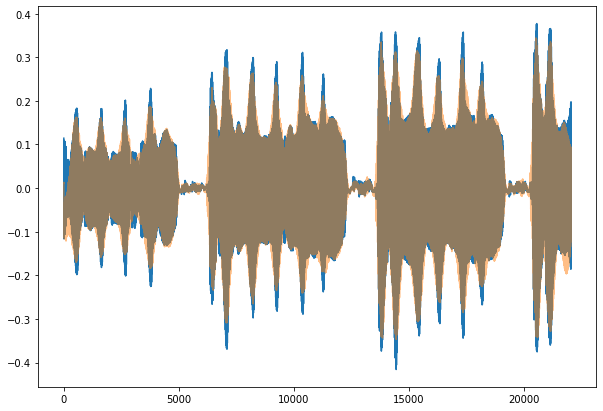

In [152]:
plt.figure(figsize=(10,7))
plt.plot(signal)
plt.plot(mod_signal*0.1116/0.1093,alpha=0.5)
plt.show()

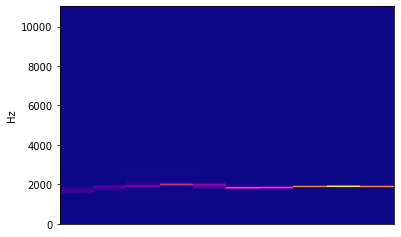

In [ ]:
librosa.display.specshow(spec_power[:,50:60], sr=sr,y_axis='linear', cmap='plasma')
plt.show()


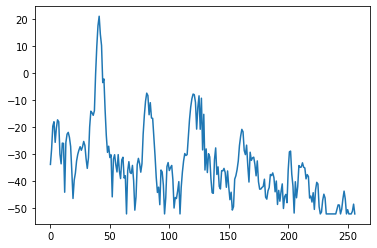

In [ ]:
plt.plot(p_to_db[:,12])

In [ ]:
test = np.fft.fft(np.abs(p_to_db[:,10]))

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


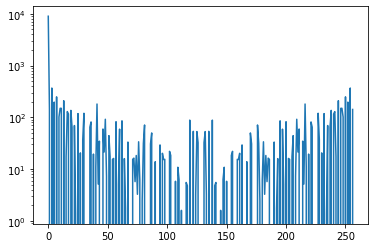

In [ ]:
plt.plot(test)
plt.yscale('log')